# 순환 신경망 이해하기

In [1]:
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')

In [2]:
# 넘파이로 구현한 간단한 RNN
import numpy as np

timesteps = 100
input_features = 32
output_features = 64

inputs = np.random.random((timesteps, input_features))

state_t = np.zeros((output_features,))

W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))

successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t

final_output_sequence = np.stack(successive_outputs, axis=0)

# 케라스의 순환 층

In [3]:
# SimpleRNN을 사용하여 마지막 타임스텝의 출력만 얻는 예제
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          320000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2080      
                                                                 
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [4]:
# SimpleRNN을 사용하여 전체 상태 시퀀스를 반환하는 예제
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [5]:
# 네트워크의 표현력을 증가시키기 위해 여러 개의 순환 층을 쌓는 예제
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 32)                2080      
                                                                 
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


## 1. SimpleRNN 예시

In [6]:
# IMDB 데이터 전처리하기
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000
maxlen = 500
batch_size = 32

print('데이터 로딩...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), '훈련 시퀀스')
print(len(input_test), '테스트 시퀀스')

print('시퀀스 패딩 (samples x time)')
input_train = sequence.data_utils.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.data_utils.pad_sequences(input_test, maxlen=maxlen)
print('input_train 크기:', input_train.shape)
print('input_test 크기:', input_test.shape)

데이터 로딩...
25000 훈련 시퀀스
25000 테스트 시퀀스
시퀀스 패딩 (samples x time)
input_train 크기: (25000, 500)
input_test 크기: (25000, 500)


In [7]:
# Embedding 층과 SimpleRNN 층을 사용한 모델 훈련하기
from keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10


2023-06-10 01:16:06.955705: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


157/157 [==============================] - 9s 56ms/step - loss: 0.6079 - acc: 0.6470 - val_loss: 0.4216 - val_acc: 0.8284
Epoch 2/10
157/157 [==============================] - 9s 55ms/step - loss: 0.3694 - acc: 0.8466 - val_loss: 0.4654 - val_acc: 0.7762
Epoch 3/10
157/157 [==============================] - 9s 56ms/step - loss: 0.2925 - acc: 0.8818 - val_loss: 0.3859 - val_acc: 0.8340
Epoch 4/10
157/157 [==============================] - 9s 57ms/step - loss: 0.2246 - acc: 0.9145 - val_loss: 0.4350 - val_acc: 0.8004
Epoch 5/10
157/157 [==============================] - 9s 57ms/step - loss: 0.1819 - acc: 0.9331 - val_loss: 0.3539 - val_acc: 0.8704
Epoch 6/10
157/157 [==============================] - 9s 57ms/step - loss: 0.1242 - acc: 0.9582 - val_loss: 0.5043 - val_acc: 0.7902
Epoch 7/10
157/157 [==============================] - 9s 57ms/step - loss: 0.0814 - acc: 0.9744 - val_loss: 0.5148 - val_acc: 0.8050
Epoch 8/10
157/157 [==============================] - 9s 57ms/step - loss: 0.054

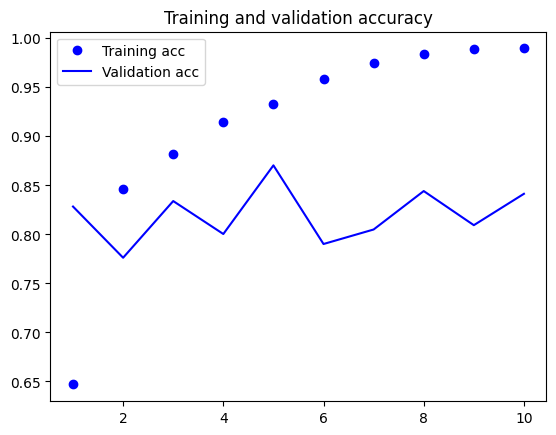

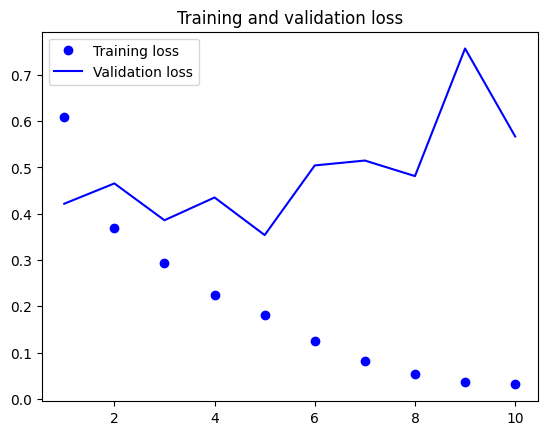

In [8]:
# 결과 그래프 그리기
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 2. LSTM 예시

In [9]:
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 33s 204ms/step - loss: 0.4837 - acc: 0.7748 - val_loss: 0.4486 - val_acc: 0.7910
Epoch 2/10
157/157 [==============================] - 33s 213ms/step - loss: 0.2812 - acc: 0.8895 - val_loss: 0.5698 - val_acc: 0.8308
Epoch 3/10
157/157 [==============================] - 32s 207ms/step - loss: 0.2302 - acc: 0.9150 - val_loss: 0.3307 - val_acc: 0.8622
Epoch 4/10
157/157 [==============================] - 33s 213ms/step - loss: 0.1987 - acc: 0.9271 - val_loss: 0.2849 - val_acc: 0.8908
Epoch 5/10
157/157 [==============================] - 31s 199ms/step - loss: 0.1745 - acc: 0.9381 - val_loss: 0.2992 - val_acc: 0.8836
Epoch 6/10
157/157 [==============================] - 30s 190ms/step - loss: 0.1552 - acc: 0.9448 - val_loss: 0.3031 - val_acc: 0.8762
Epoch 7/10
157/157 [==============================] - 35s 222ms/step - loss: 0.1379 - acc: 0.9528 - val_loss: 0.3546 - val_acc: 0.8854
Epoch 8/10
157/157 [==============================] - 3

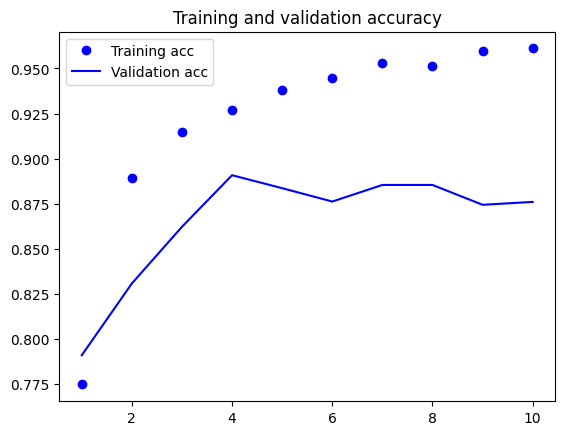

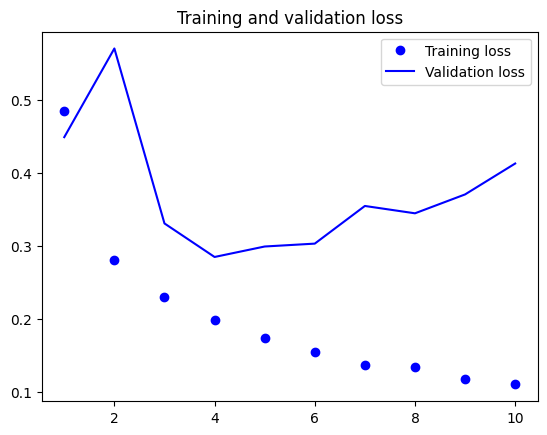

In [10]:
# 결과 그래프 그리기
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 순환 신경망의 고급 사용법

## 1. 기온 예측 문제

In [11]:
# 예나의 날씨 데이터셋 조사하기
import os

data_dir = './datasets/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [12]:
# 데이터 파싱하기
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

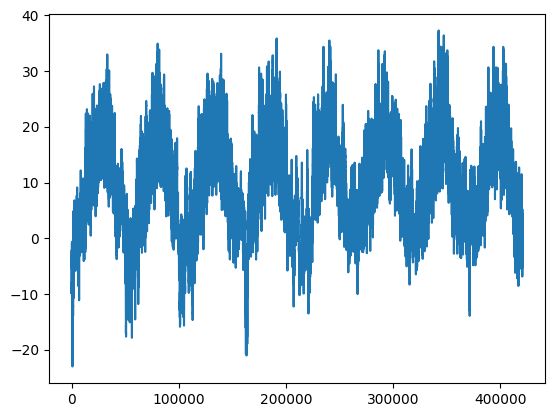

In [13]:
# 시계열 온도 그래프 그리기
from matplotlib import pyplot as plt

temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)

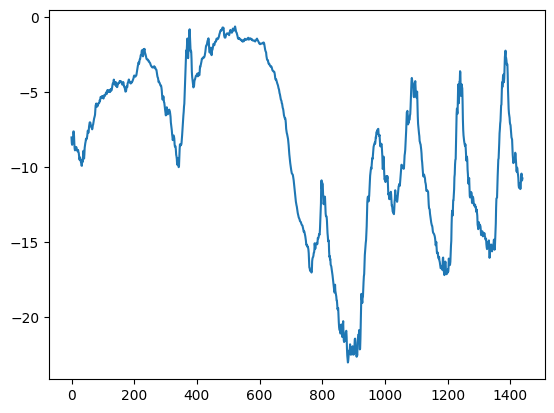

In [14]:
# 처음 10일간 온도 그래프 그리기
plt.plot(range(1440), temp[:1440])

## 2. 데이터 준비

In [15]:
# 데이터 정규화하기
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [16]:
# 시계열 데이터와 타깃을 반환하는 제너레이터 함수
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while True:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))

        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [17]:
# 훈련, 검증, 테스트 제너레이터 준비하기
lookback = 1440
step = 6
delay = 144
batch_size = 128
train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size

## 3. 상식 수준의 기준점

In [18]:
# 상식적인 기준 모델의 MAE 계산하기
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))


evaluate_naive_method()

0.2897359729905486


In [19]:
# MAE를 섭씨 단위로 변환하기
celsius_mae = 0.28 * std[1]
celsius_mae

2.4786997430172937

## 4. 기본적인 머신 러닝 방법

In [20]:
# 완전 연결 모델을 훈련하고 평가하기
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
  1/500 [..............................] - ETA: 1:08 - loss: 0.9928

/var/folders/wq/fkgy_5nd6mj8k970rhmj291c0000gn/T/ipykernel_15380/3671212215.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


500/500 [==============================] - 4s 9ms/step - loss: 1.1804 - val_loss: 0.5749
Epoch 2/20
500/500 [==============================] - 4s 8ms/step - loss: 0.3553 - val_loss: 0.3563
Epoch 3/20
500/500 [==============================] - 4s 8ms/step - loss: 0.2838 - val_loss: 0.3060
Epoch 4/20
500/500 [==============================] - 4s 8ms/step - loss: 0.2640 - val_loss: 0.3233
Epoch 5/20
500/500 [==============================] - 4s 8ms/step - loss: 0.2515 - val_loss: 0.3144
Epoch 6/20
500/500 [==============================] - 4s 9ms/step - loss: 0.2435 - val_loss: 0.3052
Epoch 7/20
500/500 [==============================] - 4s 8ms/step - loss: 0.2369 - val_loss: 0.3142
Epoch 8/20
500/500 [==============================] - 4s 8ms/step - loss: 0.2313 - val_loss: 0.3182
Epoch 9/20
500/500 [==============================] - 4s 8ms/step - loss: 0.2282 - val_loss: 0.3110
Epoch 10/20
500/500 [==============================] - 4s 8ms/step - loss: 0.2248 - val_loss: 0.3201
Epoch 11/2

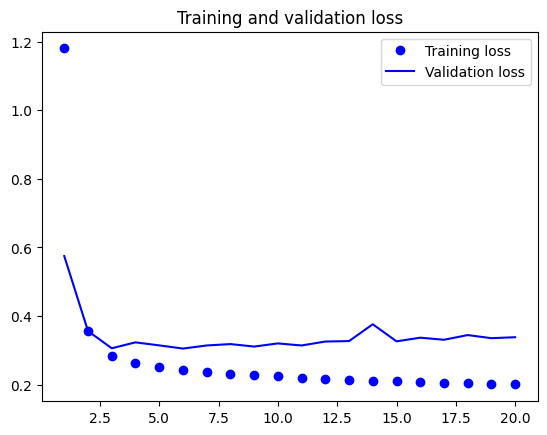

In [21]:
# 결과 그래프 그리기
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 5. 첫 번째 순환 신경망

In [22]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20


/var/folders/wq/fkgy_5nd6mj8k970rhmj291c0000gn/T/ipykernel_15380/2161899563.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


500/500 [==============================] - 35s 68ms/step - loss: 0.3021 - val_loss: 0.2749
Epoch 2/20
500/500 [==============================] - 34s 68ms/step - loss: 0.2841 - val_loss: 0.2639
Epoch 3/20
500/500 [==============================] - 34s 68ms/step - loss: 0.2780 - val_loss: 0.2662
Epoch 4/20
500/500 [==============================] - 34s 69ms/step - loss: 0.2716 - val_loss: 0.2629
Epoch 5/20
500/500 [==============================] - 35s 69ms/step - loss: 0.2677 - val_loss: 0.2640
Epoch 6/20
500/500 [==============================] - 35s 69ms/step - loss: 0.2633 - val_loss: 0.2672
Epoch 7/20
500/500 [==============================] - 35s 70ms/step - loss: 0.2592 - val_loss: 0.2685
Epoch 8/20
500/500 [==============================] - 35s 69ms/step - loss: 0.2547 - val_loss: 0.2691
Epoch 9/20
500/500 [==============================] - 35s 69ms/step - loss: 0.2512 - val_loss: 0.2662
Epoch 10/20
500/500 [==============================] - 45s 90ms/step - loss: 0.2457 - val_los

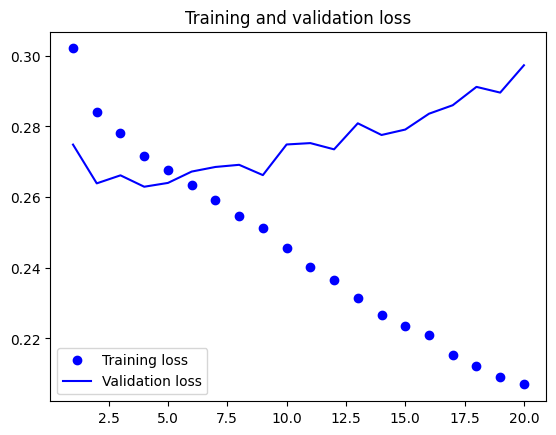

In [23]:
# 결과 그래프 그리기
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 6. 과대적합을 감소하기 위해 순환 드롭아웃 사용하기

In [24]:
# 드롭아웃 규제된 GRU를 사용한 모델을 훈련하고 평가하기
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40


/var/folders/wq/fkgy_5nd6mj8k970rhmj291c0000gn/T/ipykernel_15380/470455579.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


500/500 [==============================] - 56s 111ms/step - loss: 0.3245 - val_loss: 0.2939
Epoch 2/40
500/500 [==============================] - 56s 111ms/step - loss: 0.3026 - val_loss: 0.2751
Epoch 3/40
500/500 [==============================] - 56s 112ms/step - loss: 0.2944 - val_loss: 0.2793
Epoch 4/40
500/500 [==============================] - 56s 111ms/step - loss: 0.2900 - val_loss: 0.2718
Epoch 5/40
500/500 [==============================] - 56s 112ms/step - loss: 0.2865 - val_loss: 0.2795
Epoch 6/40
500/500 [==============================] - 56s 111ms/step - loss: 0.2797 - val_loss: 0.2714
Epoch 7/40
500/500 [==============================] - 56s 112ms/step - loss: 0.2769 - val_loss: 0.2721
Epoch 8/40
500/500 [==============================] - 55s 111ms/step - loss: 0.2715 - val_loss: 0.2753
Epoch 9/40
500/500 [==============================] - 55s 110ms/step - loss: 0.2681 - val_loss: 0.2727
Epoch 10/40
500/500 [==============================] - 56s 112ms/step - loss: 0.2662

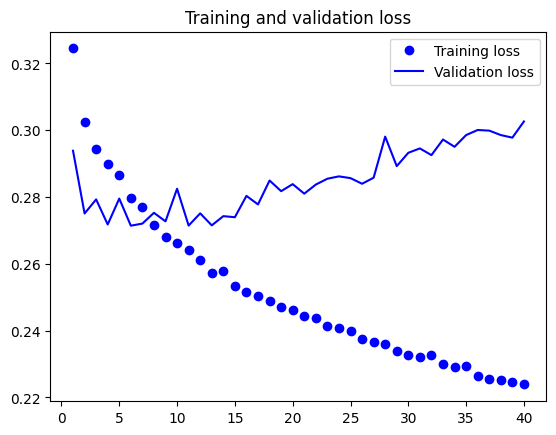

In [25]:
# 결과 그래프 그리기
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 7. 스태킹 순환 층

In [26]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1,
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40


/var/folders/wq/fkgy_5nd6mj8k970rhmj291c0000gn/T/ipykernel_15380/3101371511.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


500/500 [==============================] - 170s 338ms/step - loss: 0.3202 - val_loss: 0.2859
Epoch 2/40
500/500 [==============================] - 169s 338ms/step - loss: 0.3030 - val_loss: 0.2766
Epoch 3/40
500/500 [==============================] - 169s 338ms/step - loss: 0.2956 - val_loss: 0.2691
Epoch 4/40
500/500 [==============================] - 169s 338ms/step - loss: 0.2880 - val_loss: 0.2818
Epoch 5/40
500/500 [==============================] - 169s 338ms/step - loss: 0.2810 - val_loss: 0.2718
Epoch 6/40
500/500 [==============================] - 169s 338ms/step - loss: 0.2745 - val_loss: 0.2736
Epoch 7/40
500/500 [==============================] - 168s 337ms/step - loss: 0.2700 - val_loss: 0.2712
Epoch 8/40
500/500 [==============================] - 168s 337ms/step - loss: 0.2629 - val_loss: 0.2879
Epoch 9/40
500/500 [==============================] - 169s 338ms/step - loss: 0.2599 - val_loss: 0.2775
Epoch 10/40
500/500 [==============================] - 169s 338ms/step - lo

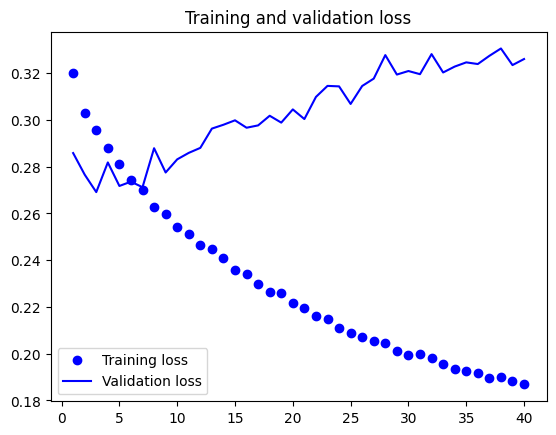

In [27]:
# 결과 그래프 그리기
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 8. 양방향 RNN 사용하기

Epoch 1/40


/var/folders/wq/fkgy_5nd6mj8k970rhmj291c0000gn/T/ipykernel_15380/3564657030.py:63: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen_reverse,


500/500 [==============================] - 55s 109ms/step - loss: 0.4898 - val_loss: 0.4855
Epoch 2/40
500/500 [==============================] - 55s 109ms/step - loss: 0.4678 - val_loss: 0.5012
Epoch 3/40
500/500 [==============================] - 55s 109ms/step - loss: 0.4296 - val_loss: 0.4258
Epoch 4/40
500/500 [==============================] - 55s 109ms/step - loss: 0.3781 - val_loss: 0.3779
Epoch 5/40
500/500 [==============================] - 55s 109ms/step - loss: 0.3362 - val_loss: 0.3093
Epoch 6/40
500/500 [==============================] - 55s 109ms/step - loss: 0.3039 - val_loss: 0.3081
Epoch 7/40
500/500 [==============================] - 55s 109ms/step - loss: 0.2908 - val_loss: 0.2991
Epoch 8/40
500/500 [==============================] - 55s 110ms/step - loss: 0.2862 - val_loss: 0.2899
Epoch 9/40
500/500 [==============================] - 55s 109ms/step - loss: 0.2785 - val_loss: 0.2905
Epoch 10/40
500/500 [==============================] - 55s 109ms/step - loss: 0.2764

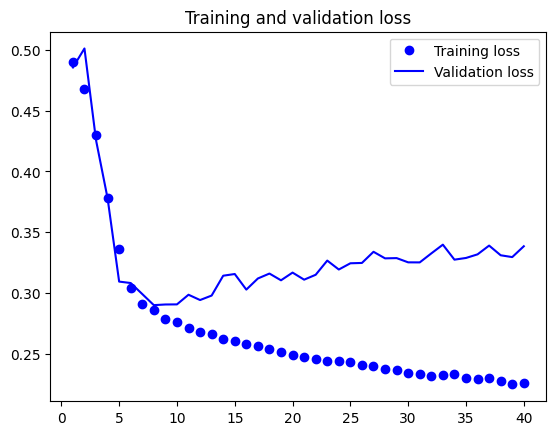

In [28]:
# 거꾸로 뒤집힌 시퀀스로 훈련된 GRU

# 시계열 데이터와 타깃을 반환하는 제너레이터 함수
import matplotlib.pyplot as plt
from keras.optimizers import RMSprop
from keras import layers
from keras.models import Sequential


def generator_reverse(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while True:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))

        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets


# 훈련, 검증, 테스트 제너레이터 준비하기
lookback = 1440
step = 6
delay = 144
batch_size = 128
train_gen_reverse = generator_reverse(float_data,
                                      lookback=lookback,
                                      delay=delay,
                                      min_index=0,
                                      max_index=200000,
                                      shuffle=True,
                                      step=step,
                                      batch_size=batch_size)
val_gen_reverse = generator_reverse(float_data,
                                    lookback=lookback,
                                    delay=delay,
                                    min_index=200001,
                                    max_index=300000,
                                    step=step,
                                    batch_size=batch_size)

# 드롭아웃 규제된 GRU를 사용한 모델을 훈련하고 평가하기
model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen_reverse,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen_reverse,
                              validation_steps=val_steps)

# 결과 그래프 그리기
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [29]:
# 거꾸로 된 시퀀스를 사용한 LSTM을 훈련하고 평가하기
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

max_features = 10000
maxlen = 500

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

x_train = sequence.data_utils.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.data_utils.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 40s 249ms/step - loss: 0.5389 - acc: 0.7257 - val_loss: 0.3853 - val_acc: 0.8408
Epoch 2/10
157/157 [==============================] - 41s 264ms/step - loss: 0.3270 - acc: 0.8726 - val_loss: 0.5702 - val_acc: 0.7610
Epoch 3/10
157/157 [==============================] - 41s 260ms/step - loss: 0.2618 - acc: 0.9002 - val_loss: 0.3099 - val_acc: 0.8798
Epoch 4/10
157/157 [==============================] - 40s 255ms/step - loss: 0.2193 - acc: 0.9205 - val_loss: 0.3191 - val_acc: 0.8780
Epoch 5/10
157/157 [==============================] - 42s 265ms/step - loss: 0.1949 - acc: 0.9295 - val_loss: 0.3526 - val_acc: 0.8536
Epoch 6/10
157/157 [==============================] - 41s 262ms/step - loss: 0.1708 - acc: 0.9394 - val_loss: 0.3872 - val_acc: 0.8660
Epoch 7/10
157/157 [==============================] - 42s 265ms/step - loss: 0.1469 - acc: 0.9488 - val_loss: 0.3816 - val_acc: 0.8546
Epoch 8/10
157/157 [==============================] - 4

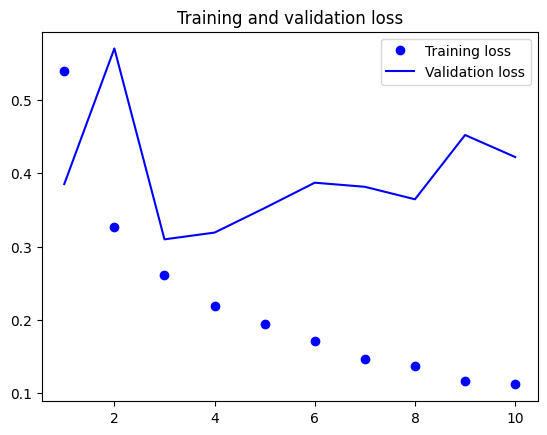

In [30]:
# 결과 그래프 그리기
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [31]:
# 양방향 LSTM을 훈련하고 평가하기
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 27s 164ms/step - loss: 0.5482 - acc: 0.7344 - val_loss: 0.4416 - val_acc: 0.8272
Epoch 2/10
157/157 [==============================] - 26s 165ms/step - loss: 0.3860 - acc: 0.8505 - val_loss: 0.3204 - val_acc: 0.8790
Epoch 3/10
157/157 [==============================] - 26s 164ms/step - loss: 0.2746 - acc: 0.8979 - val_loss: 0.4162 - val_acc: 0.8640
Epoch 4/10
157/157 [==============================] - 28s 180ms/step - loss: 0.2263 - acc: 0.9190 - val_loss: 0.3030 - val_acc: 0.8858
Epoch 5/10
157/157 [==============================] - 26s 167ms/step - loss: 0.2058 - acc: 0.9281 - val_loss: 0.3469 - val_acc: 0.8898
Epoch 6/10
157/157 [==============================] - 25s 157ms/step - loss: 0.1900 - acc: 0.9378 - val_loss: 0.3187 - val_acc: 0.8768
Epoch 7/10
157/157 [==============================] - 25s 160ms/step - loss: 0.1656 - acc: 0.9420 - val_loss: 0.5707 - val_acc: 0.8134
Epoch 8/10
157/157 [==============================] - 2

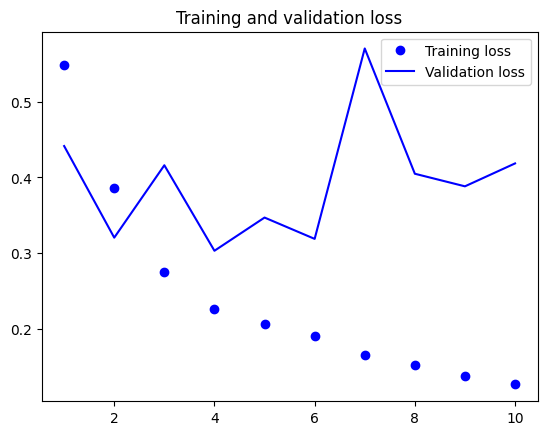

In [32]:
# 결과 그래프 그리기
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Epoch 1/40


/var/folders/wq/fkgy_5nd6mj8k970rhmj291c0000gn/T/ipykernel_15380/3674041845.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


500/500 [==============================] - 53s 103ms/step - loss: 0.3039 - val_loss: 0.2848
Epoch 2/40
500/500 [==============================] - 35s 70ms/step - loss: 0.2747 - val_loss: 0.2677
Epoch 3/40
500/500 [==============================] - 35s 70ms/step - loss: 0.2673 - val_loss: 0.2692
Epoch 4/40
500/500 [==============================] - 35s 70ms/step - loss: 0.2622 - val_loss: 0.2695
Epoch 5/40
500/500 [==============================] - 35s 71ms/step - loss: 0.2575 - val_loss: 0.2724
Epoch 6/40
500/500 [==============================] - 35s 70ms/step - loss: 0.2516 - val_loss: 0.2687
Epoch 7/40
500/500 [==============================] - 35s 70ms/step - loss: 0.2469 - val_loss: 0.2698
Epoch 8/40
500/500 [==============================] - 35s 70ms/step - loss: 0.2371 - val_loss: 0.2758
Epoch 9/40
500/500 [==============================] - 35s 70ms/step - loss: 0.2360 - val_loss: 0.2762
Epoch 10/40
500/500 [==============================] - 35s 71ms/step - loss: 0.2296 - val_lo

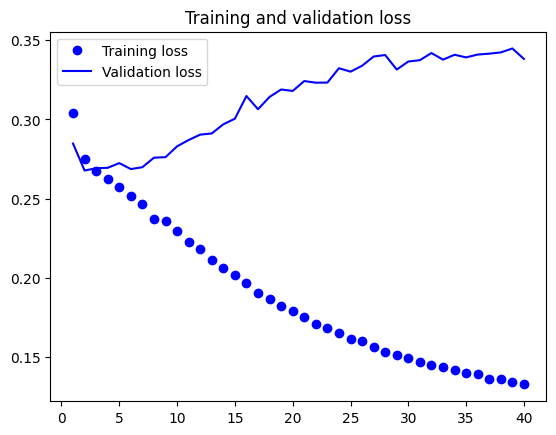

In [33]:
# 동일한 방식을 온도 예측 문제에 적용
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

# 결과 그래프 그리기
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 컨브넷을 사용한 시퀀스 처리

## 1. 1D 컨브넷 구현

In [34]:
# IMDB 데이터 전처리하기
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000
max_len = 500

print('데이터 로드...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), '훈련 시퀀스')
print(len(x_test), '테스트 시퀀스')

print('시퀀스 패딩 (samples x time)')
x_train = sequence.data_utils.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.data_utils.pad_sequences(x_test, maxlen=maxlen)
print('x_train 크기:', x_train.shape)
print('x_test 크기:', x_test.shape)

데이터 로드...
25000 훈련 시퀀스
25000 테스트 시퀀스
시퀀스 패딩 (samples x time)
x_train 크기: (25000, 500)
x_test 크기: (25000, 500)


In [35]:
# IMDB 데이터에 1D 컨브넷을 훈련하고 평가하기
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 500, 128)          1280000   
                                                                 
 conv1d (Conv1D)             (None, 494, 32)           28704     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 98, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 92, 32)            7200      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_11 (Dense)            (None, 1)               

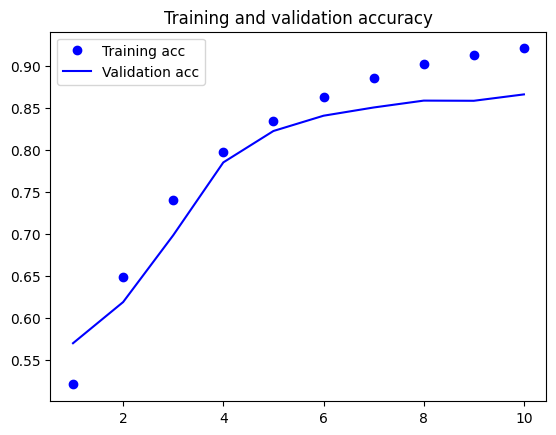

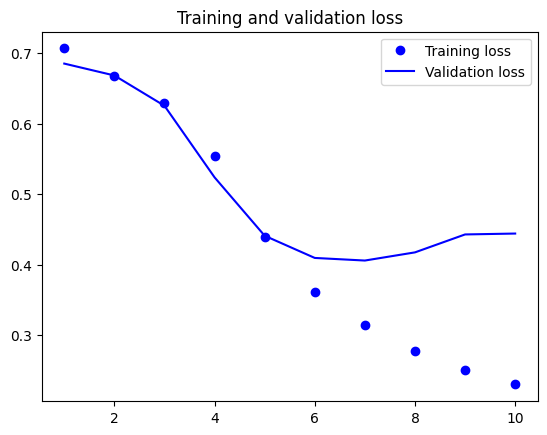

In [36]:
# 결과 그래프 그리기
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 2. CNN과 RNN을 연결하여 긴 시퀀스를 처리하기

In [37]:
# 예나 데이터에서 1D 컨브넷을 훌련하고 평가하기
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu', input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20


/var/folders/wq/fkgy_5nd6mj8k970rhmj291c0000gn/T/ipykernel_15380/168278102.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


500/500 [==============================] - 8s 15ms/step - loss: 0.4338 - val_loss: 0.4873
Epoch 2/20
500/500 [==============================] - 7s 15ms/step - loss: 0.3910 - val_loss: 0.4556
Epoch 3/20
500/500 [==============================] - 7s 15ms/step - loss: 0.3742 - val_loss: 0.4584
Epoch 4/20
500/500 [==============================] - 7s 15ms/step - loss: 0.3639 - val_loss: 0.4568
Epoch 5/20
500/500 [==============================] - 7s 15ms/step - loss: 0.3549 - val_loss: 0.4632
Epoch 6/20
500/500 [==============================] - 7s 15ms/step - loss: 0.3473 - val_loss: 0.4509
Epoch 7/20
500/500 [==============================] - 7s 14ms/step - loss: 0.3408 - val_loss: 0.4686
Epoch 8/20
500/500 [==============================] - 7s 14ms/step - loss: 0.3348 - val_loss: 0.4549
Epoch 9/20
500/500 [==============================] - 7s 14ms/step - loss: 0.3328 - val_loss: 0.4595
Epoch 10/20
500/500 [==============================] - 7s 14ms/step - loss: 0.3285 - val_loss: 0.4572


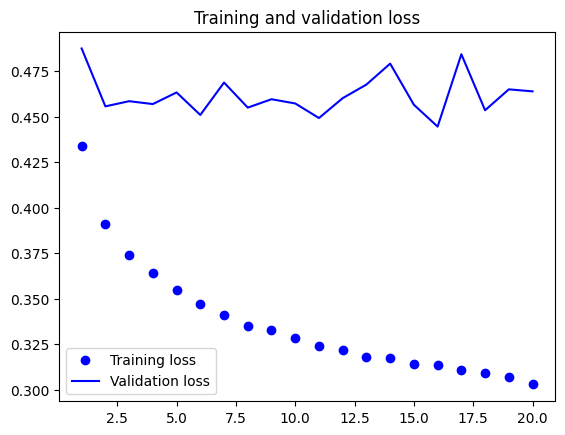

In [38]:
# 결과 그래프 그리기
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [39]:
# 고밀도 데이터 제너레이터로 예나 데이터셋 준비하기
step = 3
lookback = 1440
delay = 144

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step)
val_steps = (300000 - 200001 - lookback) // 128
test_steps = (len(float_data) - 300001 - lookback) // 128

In [40]:
# 1D 합성곱과 GRU 층을 연결한 모델
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu', input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, None, 32)          2272      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, None, 32)         0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, None, 32)          5152      
                                                                 
 gru_6 (GRU)                 (None, 32)                6336      
                                                                 
 dense_13 (Dense)            (None, 1)                 33        
                                                                 
Total params: 13,793
Trainable params: 13,793
Non-trainable params: 0
_________________________________________________

/var/folders/wq/fkgy_5nd6mj8k970rhmj291c0000gn/T/ipykernel_15380/2165897942.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


500/500 [==============================] - 54s 107ms/step - loss: 0.3298 - val_loss: 0.2815
Epoch 2/20
500/500 [==============================] - 54s 108ms/step - loss: 0.2967 - val_loss: 0.2848
Epoch 3/20
500/500 [==============================] - 54s 108ms/step - loss: 0.2809 - val_loss: 0.2756
Epoch 4/20
500/500 [==============================] - 55s 109ms/step - loss: 0.2705 - val_loss: 0.2895
Epoch 5/20
500/500 [==============================] - 55s 109ms/step - loss: 0.2630 - val_loss: 0.2782
Epoch 6/20
500/500 [==============================] - 54s 109ms/step - loss: 0.2576 - val_loss: 0.2792
Epoch 7/20
500/500 [==============================] - 55s 109ms/step - loss: 0.2486 - val_loss: 0.2835
Epoch 8/20
500/500 [==============================] - 54s 108ms/step - loss: 0.2441 - val_loss: 0.3032
Epoch 9/20
500/500 [==============================] - 54s 108ms/step - loss: 0.2369 - val_loss: 0.2919
Epoch 10/20
500/500 [==============================] - 54s 108ms/step - loss: 0.2319

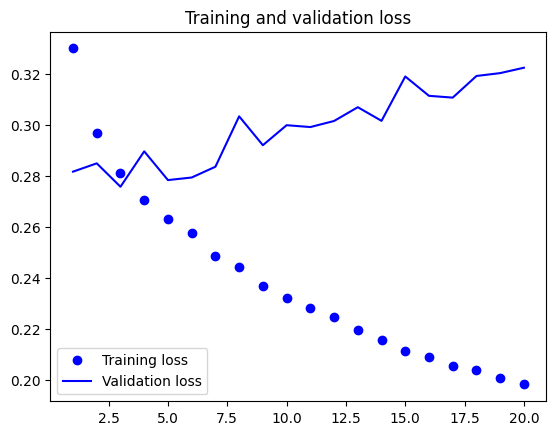

In [41]:
# 결과 그래프 그리기
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()